In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data
The planet dataset isn't available on the fastai dataset page due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add source activate fastai or similar, or prefix pip with a path. Have a look at how conda install is called for your platform in the appropriate Returning to work section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [4]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/Tim/.fastai/data/planet')

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  

issue: SyntaxError: invalid syntax

solution: https://github.com/Kaggle/kaggle-api/issues/12


issue: 403 Forbidden:

solution: Join Competition and Accept rules

https://github.com/Kaggle/kaggle-api/issues/87 

In [6]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path} 

In [7]:
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

## Multiclassification
Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a DataBunch while using the data block API(https://docs.fast.ai/data_block.html), we then need to using ImageList (and not ImageDataBunch). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\'.

In [10]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [11]:
data = (src.transform(tfms, size=128)
        .databunch(bs=12).normalize(imagenet_stats))

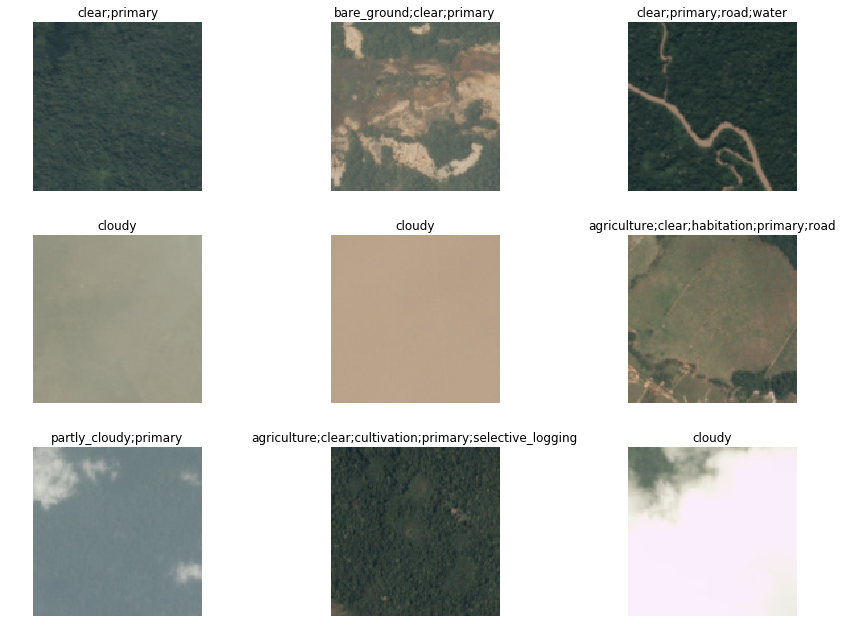

In [12]:
data.show_batch(rows=3, figsize=(12,9))

To create a Learner we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use accuracy_thresh instead of accuracy. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. accuracy_thresh selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See here https://en.wikipedia.org/wiki/F1_score for more details.

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score]).to_fp16()

We use the LR Finder to pick a good learning rate.

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.

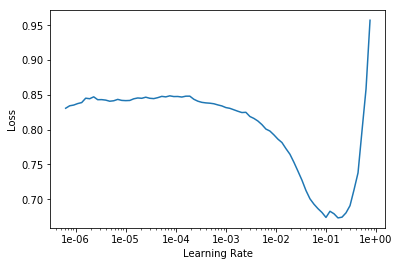

In [17]:
learn.recorder.plot()

In [18]:
lr = 0.016

#### Don't train on local PC if GPU is not powerful enough
my 980MX laptop GPU takes nearly 30min to finish one epoch, too slow

In [19]:
1e-2/2

0.005

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.588179,0.192919,0.894584,0.793050,00:59
1,0.340343,0.177051,0.930111,0.849066,01:00
2,0.255920,0.180563,0.915550,0.815254,00:58
3,0.204114,0.163563,0.930111,0.822619,01:01
4,0.175613,0.156727,0.930111,0.821839,00:59


In [ ]:
learn.save('stage-1-rn50')